In [1]:
# !wget https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh -O miniconda.sh
# !bash miniconda.sh -b
# print('Installed miniconda...')
# conda_path = '/root/miniconda3/bin'
# import os
# os.environ["PATH"] += os.pathsep + conda_path
# print('Added conda to PATH...')
# !conda clean --packages -y
# !conda install -y numba
# print('Installed numba...')
# !conda install -y datashader
# print('Installed datashader...')
# import sys
# conda_path = '/root/miniconda3/lib/python3.6/site-packages/'
# if conda_path not in sys.path:
#     sys.path.insert(0, conda_path)
# print('Added the conda packages to PYTHONPATH')

In [2]:
%autosave 60
%matplotlib inline

Autosaving every 60 seconds


In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import importlib
import logging
import sys
import time
import pickle
# from numba import jit

In [5]:
import keras
from keras.callbacks import EarlyStopping
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
# Plotting the LSTM-NN
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [6]:
# Pandas fancy tables
pd.set_option('display.notebook_repr_html', True)
pd.set_option('max_rows', 100)
# Matplotlib fancy plots
plt.style.use('ggplot')
# Logger setup
importlib.reload(logging)

LOGGING_FORMAT = '%(levelname)s | line %(lineno)s | %(funcName)s | %(message)s'
logging.basicConfig(format=LOGGING_FORMAT, level=logging.INFO, 
                    stream=sys.stdout, datefmt='%H:%M:%S')

# Numpy printing setup
np.set_printoptions(threshold=100, linewidth=79, edgeitems=5)

<module 'logging' from '/usr/local/lib/python3.6/logging/__init__.py'>

In [7]:
def get_root():
    return os.path.abspath(os.sep)

MERGED_FOLDER = os.path.join('data', 'merged')

MERGED_FNAME = 'stocks_all_merged.csv'

SCALED_PATH = os.path.join(MERGED_FOLDER, SCALED_FNAME)
MERGED_PATH = os.path.join(MERGED_FOLDER, MERGED_FNAME)

In [8]:
logging.info('Reading the merged dataset...')
df_merged = pd.read_csv(MERGED_PATH, index_col=0)
df_merged.fillna(0, inplace=True)
df_merged.reset_index(drop=True, inplace=True)
logging.info('Finished processing the merged dataset')

INFO | line 9 | <module> | Reading the merged dataset...
INFO | line 13 | <module> | Finished processing the merged dataset


In [9]:
def scale_series(col):
    return (col - col.min()) / (col.max() - col.min())

def convert_series(df_merged, window=30, pred_column='A', do_pca=False, pca=None, feature_len=None):
    X = []
    y = []
    col_number = df_merged.columns.get_loc('A')

    logging.info('Starting scaling...')    
    scaler = MinMaxScaler(feature_range=(0,1))
    data_scaled = scaler.fit_transform(df_merged.as_matrix())
    logging.info('Finished scaling')
    
    data_y = data_scaled[:, col_number]
    data_X = data_scaled

    # Doing the princomp analysis to reduce dims
    if do_pca:
        if pca is None:
            logging.info('Executing PCA...')    
            pca = PCA(feature_len)
            pca.fit(data_X)        
        data_X = pca.transform(data_X)

    logging.info(f'Number of features: {data_X.shape[1]}')
    
    # Processing X, y
    logging.info('Making X, y datasets')
    range_index = range(data_X.shape[0] - window - 1)
    for i in range_index:
        X.append(data_X[i: i + window])
        y.extend(data_y[i + window: i + window + 1])

    X = np.stack(X)
    y = np.array(y)
    return X, y, pca, scaler

def split_x_y(df, pred_column='A', window=30, test_rows=260, do_pca=False, pca=None, feature_len=None):
    # Converting the dataframe to something we can feed NN with
    logging.info('Converting dataframe to X,y')
    X, y, pca, scaler = convert_series(df, window, pred_column, do_pca, pca, feature_len)
    # Splitting the datasets
    logging.info('Splitting X,y into train and test datasets')
    X_train = X[:-test_rows]
    y_train = y[:-test_rows]
    X_test = X[-test_rows:]
    y_test = y[-test_rows:]
    return X_train, y_train, X_test, y_test, pca, scaler

In [10]:
pca = None
# with open('pca.pickle', 'rb') as f:
#     pca = pickle.load(f)
logging.info('Splitting the data into train and test datasets as well as converting it to the correct format')
X_train, y_train, X_test, y_test, pca, scaler = split_x_y(df_merged, pca=pca)
logging.info('Finished data preprocessing')

INFO | line 4 | <module> | Splitting the data into train and test datasets as well as converting it to the correct format
INFO | line 40 | split_x_y | Converting dataframe to X,y
INFO | line 9 | convert_series | Starting scaling...
INFO | line 12 | convert_series | Finished scaling
INFO | line 25 | convert_series | Number of features: 10228
INFO | line 28 | convert_series | Making X, y datasets
INFO | line 43 | split_x_y | Splitting X,y into train and test datasets
INFO | line 6 | <module> | Finished data preprocessing


In [11]:
# logging.info('Saving the PCA object...')
# with open('pca.pickle', 'wb') as f:
#     pickle.dump(pca, f)
# logging.info('Finished saving the pca object')

In [12]:
def predict_sequences_multiple(model, data, window_size, prediction_len):
    # Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(len(data) // prediction_len):
        curr_frame = data[i * prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[np.newaxis, :, :])[0, 0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(
                curr_frame, [window_size - 1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    # Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
#     plt.title(f'MIDL {mid_lyr} EP{epochs} BTCH{batches}')
    plt.legend()
#     if not os.path.exists('plots'):
#         os.makedirs('plots')
#     plt.savefig(f'plots/ml{mid_lyr}_b{batches}_e{epochs}.png')
    plt.show()

In [21]:
def make_one_layer_lstm(num_neurons=2000):
    #input shape = (nb_samples,timesteps =30, input_dim= cols)
    logging.info('Started making one-layer model with {num_neurons} lstm cells...')
    model = Sequential()

    # Input layer
    logging.info('Processing input layer and hidden layer #1...')
    model.add(LSTM(
        num_neurons,
        return_sequences=False,
        input_shape=(X_train.shape[1], X_train.shape[2]),#X_train.shape[1]
        dropout=0.1
    ))

    # Output layer
    logging.info('Processing output layer...')
    model.add(Dense(
        1,
        activation='linear'
    ))
    logging.info('Finished making the model')

    # Compiling the model
    logging.info('Started compilation...')
    start_time=time.time()
    model.compile(loss='mse', optimizer='adam')
    logging.info('Compiled in {}s'.format(time.time()-start_time))
    return model

In [22]:
def make_two_layer_lstm(first_layer=1000, second_layer=200):
    #input shape = (nb_samples,timesteps =30, input_dim= cols)
    logging.info('Started making a 2-layer model, l1={first_layer}, l2=second_layer...')
    model = Sequential()

    # Input layer
    logging.info('Processing input layer and hidden layer #1...')
    model.add(LSTM(
        first_layer,
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2]),#X_train.shape[1]
        dropout=0.1
    ))

    # Hidden layer #1
    logging.info('Processing hidden layer #2...')
    model.add(LSTM(
        second_layer,
        return_sequences=False,
        dropout=0.2
    ))

    # Output layer
    logging.info('Processing output layer...')
    model.add(Dense(
        1,
        activation='linear'
    ))
    logging.info('Finished making the model')

    # Compiling the model
    logging.info('Started compilation...')
    start_time=time.time()
    model.compile(loss='mse', optimizer='adam')
    logging.info('Compiled in {}s'.format(time.time()-start_time))
    return model

In [23]:
def plot_pred(model, X_test, y_test):
    fig = plt.figure()
    _ = plt.plot(y_test, label='True data')
    y_pred = model.predict(X_test)
    _ = plt.plot(y_pred, label=f'Prediction')
    _ = plt.legend(fancybox=True, shadow=False)
    plt.show()

INFO | line 3 | make_one_layer_lstm | Started making one-layer model with {num_neurons} lstm cells...
INFO | line 7 | make_one_layer_lstm | Processing input layer and hidden layer #1...
INFO | line 16 | make_one_layer_lstm | Processing output layer...
INFO | line 21 | make_one_layer_lstm | Finished making the model
INFO | line 24 | make_one_layer_lstm | Started compilation...
INFO | line 27 | make_one_layer_lstm | Compiled in 0.019028425216674805s
INFO | line 3 | <module> | Current model:


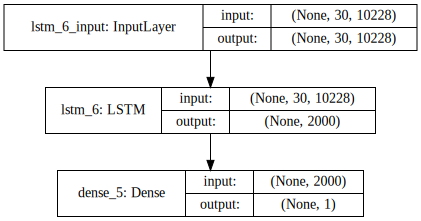

Train on 3588 samples, validate on 399 samples
Epoch 1/200
3588/3588 [==============================] - 68s - loss: 4.3767 - val_loss: 0.0046
Epoch 2/200
3588/3588 [==============================] - 67s - loss: 0.0032 - val_loss: 0.0024
Epoch 3/200
3588/3588 [==============================] - 67s - loss: 0.0020 - val_loss: 8.8546e-04
Epoch 4/200
3588/3588 [==============================] - 67s - loss: 0.0013 - val_loss: 4.0301e-04
Epoch 5/200
3588/3588 [==============================] - 67s - loss: 9.2977e-04 - val_loss: 4.1961e-04
Epoch 6/200
3588/3588 [==============================] - 67s - loss: 7.1712e-04 - val_loss: 3.7221e-04
Epoch 7/200
3588/3588 [==============================] - 67s - loss: 5.9788e-04 - val_loss: 6.9179e-04
Epoch 8/200
3588/3588 [==============================] - 67s - loss: 5.1777e-04 - val_loss: 6.1685e-04
Epoch 9/200
3588/3588 [==============================] - 67s - loss: 4.4020e-04 - val_loss: 4.4394e-04
Epoch 10/200
3588/3588 [==========================

260/260 [==============================] - 1s     


0.0040287094925028771

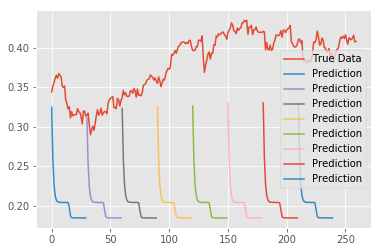

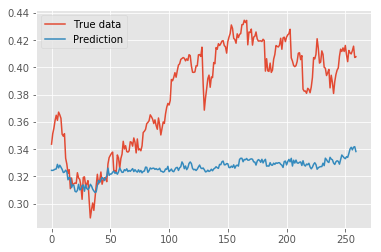

INFO | line 3 | make_two_layer_lstm | Started making a 2-layer model, l1={first_layer}, l2=second_layer...
INFO | line 7 | make_two_layer_lstm | Processing input layer and hidden layer #1...
INFO | line 16 | make_two_layer_lstm | Processing hidden layer #2...
INFO | line 24 | make_two_layer_lstm | Processing output layer...
INFO | line 29 | make_two_layer_lstm | Finished making the model
INFO | line 32 | make_two_layer_lstm | Started compilation...
INFO | line 35 | make_two_layer_lstm | Compiled in 0.01978278160095215s
INFO | line 3 | <module> | Current model:


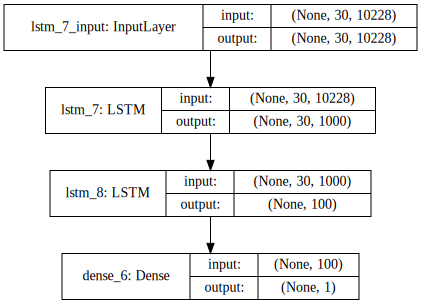

Train on 3588 samples, validate on 399 samples
Epoch 1/200
3588/3588 [==============================] - 44s - loss: 0.2047 - val_loss: 0.0027
Epoch 2/200
3588/3588 [==============================] - 43s - loss: 0.0046 - val_loss: 4.2929e-04
Epoch 3/200
3588/3588 [==============================] - 43s - loss: 0.0030 - val_loss: 5.3176e-04
Epoch 4/200
3588/3588 [==============================] - 43s - loss: 0.0022 - val_loss: 0.0011
Epoch 5/200
3588/3588 [==============================] - 43s - loss: 0.0018 - val_loss: 8.3219e-04
Epoch 6/200
3588/3588 [==============================] - 43s - loss: 0.0014 - val_loss: 7.9893e-04


260/260 [==============================] - 1s     


0.0069336214317725258

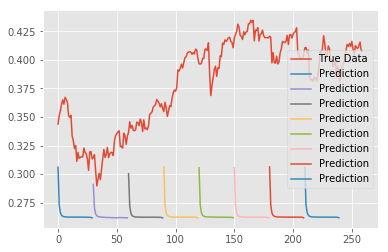

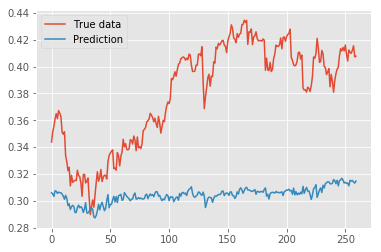

In [24]:
for model_fun in  [make_one_layer_lstm, make_two_layer_lstm]:
    model = model_fun()
    logging.info('Current model:')
    SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
    model.save_weights('test_weights.h5')
    for epoch_size in [200]:
        # Stop if we haven't improved for X epochs
        model.load_weights('test_weights.h5')
        
        early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=3)
        
        model.fit(
            X_train,
            y_train,
            batch_size=30,
            epochs=epoch_size,
            validation_split=0.1,
            shuffle=True,
            callbacks=[early_stopping_monitor]
        )
        
        model.evaluate(X_test, y_test)

        y_pred = predict_sequences_multiple(model, X_test, 30, 30)
        plot_results_multiple(y_pred, y_test, 30)
        plot_pred(model, X_test, y_test)
        model.save(f'{model_fun.__name__}_e{epoch_size}.h5')

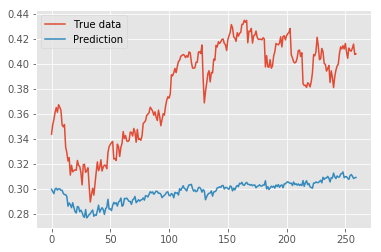

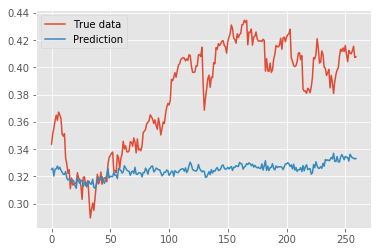

In [20]:
models = [i for i in os.listdir() if '.h5' in i and 'weight' not in i]
for i in models:
    plot_pred(load_model(i), X_test, y_test)